# Exercise - Terschelling NDVI using CoCliCo & MPC STAC

In this exercise we are going to use both the MPC and Deltares CoCliCo STAC to look at vegetation change on the island of Terschelling. For this, we load the Coastal Mask in the CoCliCo STAC and overlay it on Sentinel-2 derived NDVI images from the MPC STAC. Eventually we will make some interactive plots, both in space & time and compute some statistics.

### Add project directory to Python path

This code defines two functions and retrieves the project directory path. It's useful when we want to define some generic functions that can be imported. If you retrieve the project directoy path like this, it both works in an Ipython and Python environment. 

- `is_interactive()`: Checks if the code is running in an interactive environment.
- `get_proj_dir()`: Determines the project directory path based on the execution context. If running interactively, it infers the project directory from the Jupyter kernel. Otherwise, it infers it from the Python file. The function returns the project directory as a `pathlib.Path` object.

In [ ]:
import os
import pathlib
import sys


def is_interactive() -> bool:
    """
    Check if the Python code is running in an interactive environment.
    """
    import __main__ as main

    return not hasattr(main, "__file__")


def get_proj_dir() -> pathlib.Path:
    """
    Get the project directory path.

    Returns:
        A `pathlib.Path` object representing the project directory path.
    """
    if is_interactive():
        print("Inferring project directory from the Jupyter kernel.")
        cwd = pathlib.Path().resolve()
        proj_dir = cwd.parent
    else:
        print("Inferring project directory from the Python file.")
        cwd = pathlib.Path(__file__)
        proj_dir = cwd.parent.parent

    return proj_dir


proj_dir: pathlib.Path = get_proj_dir()
sys.path.append(str(proj_dir / "src"))

### Import libraries

In [ ]:
import colorcet as cc
import dask
import geopandas as gpd
import hvplot.pandas  # noqa
import hvplot.xarray  # noqa
import pandas as pd
import panel as pn
import planetary_computer
import pystac_client
import stackstac
import xarray as xr

# from azure.storage.blob import BlobServiceClient
from dask.distributed import Client
from ipyleaflet import Map, basemaps

### Load the Region of Interest (RoI) - Terschelling

In [ ]:
m = Map(basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True)
m.center = 53.4, 5.35  # Terschelling
m.zoom = 12
m.layout.height = "800px"
m

Extract the coords from the interactive map -- IMPORTANT: wait 2 seconds until map is rendered, otherwise you cannot extract the coords. Call this `roi`

### Load the CoCliCo STAC catalog (developed by Deltares within the [CoCliCo project](https://coclicoservices.eu/))

See the STAC here: [CoCliCo STAC](https://radiantearth.github.io/stac-browser/#/external/storage.googleapis.com/dgds-data-public/coclico/coclico-stac/catalog.json?.language=en). Notice that this STAC is still in development, i.e. there are some double links and it doesn't look as nice as the [MPC STAC](https://radiantearth.github.io/stac-browser/#/external/planetarycomputer.microsoft.com/api/stac/v1?.language=en). Yet, is also contains some nice datasets already.

Load the CoCliCo STAC

Print all the datasets in the STAC

### Open the Coastal Mask dataset and filter on the RoI

Open the Coastal Mask dataset. Note, the CoCliCo STAC has not built-in search / metadata filter function enabled. Hence, you approach it differently than the MPC or DEA STACs. This would typically be documented in the user manual, which is still under development for CoCliCo.

In [ ]:
cm_collection = catalog.get_collection("cm")
cm_items = list(cm_collection.get_all_items())

Explore an item

Check all the Coasl Mask bounding boxes on a map, tip: bbox is a property from the items

In [ ]:
cm_bboxes = pd.concat([geo_bbox(*i.to_dict()["bbox"]) for i in cm_items])
cm_bboxes = cm_bboxes.reset_index(drop=True)
cm_bboxes.explore()

Spatial join the Coastal Mask boxes on the RoI

In [ ]:
cm_bboxes_roi = gpd.sjoin(cm_bboxes, roi)[cm_bboxes.columns]
cm_bboxes_roi.explore()

Obtain all Coastal Mask STAC hrefs in the remaining RoI items

In [ ]:
# obtain STAC items that cover the ROI
items_roi = [cm_items[i] for i in cm_bboxes_roi.index]
cm_hrefs = [i.assets["cm"].href for i in items_roi]
# cm_hrefs

### Local Dask cluster

Here we launch a local Dask cluster, a Python-based multiprocessing library, which will speed up the computation. The cluster we make here is local, when you want to upscale your computations you should use a Dask gateway, hosted on a remote server, close to the data.

### Read the Coastal Mask data in the RoI 

Read the Coastal Mask lazily using Xarray with a rasterio engine

In [ ]:
%%time
@dask.delayed
def lazy_open(href):
    chunks = dict(band=1, x=512, y=512)
    return xr.open_dataset(href, chunks=chunks, engine="rasterio")


das = dask.compute(
    *[lazy_open(href) for href in cm_hrefs]
)  # here we start the computation
print(f"len das: {len(das)}")
das[0]

Combine the coordinates in the Xarray Coastal Mask dataset

In [ ]:
%%time
cm = xr.combine_by_coords(das).compute()

Plot the Coastal Mask using HoloViz's hvplot

### Load the Microsoft Planetary Computer (MPC) STAC catalog 

Have a look at their [documentation](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) for examples

Load the MPC STAC

Print all the datasets in the STAC

### Open the S2 dataset and filter on a cloud cover, datetime and the RoI

Open the S2 dataset and print all items, do this for the timeframe: `2022-07-01/2023-06-22` and cloudcover: `lt: 50`

list all bands within the S2 collection, together with its description

Merge all items in a `xr.dataArray` 

### Compute the NDVI and make an interactive plot

Compute the NDVI (red & nir band), call it `ndvi`

Make an interactive plot for the second timestep in the NDVI dataArray

### Combine the NDVI from MPC and Coastal Mask from CoCliCo

We could directly match the NDVI (MPC) and Coastal Mask (CoCliCo) data as both are rasters. However, these do need to have the same coordinates / raster to overlay it properly. `Reindex` the Coastal Mask layer to match the NDVI raster with a tolerance of 0.001 and a fill value of 0.

In [ ]:
cmr = cm.reindex(x=ndvi.x, y=ndvi.y, method="nearest", tolerance=0.001, fill_value=0)

Make a plot of the newly constructed Coastal Mask and check your reindexing. The Coastal Mask should now have the same RoI as the NDVI layer.

Mask the NDVI layer with the reindexed Coastal Mask layer to get rid of the oceanic information. Plot the second timestep in the masked NDVI dataArray

### Make a dashboard from the data using Panel, in which you can slide through the time steps

### Make a timeseries plot from the data using HvPlot

Make a timeseries plot from the single image mean NDVI values within the masked NDVI layer. Here, you will see the seasonal oscillation in the NDVI. In the autumn / winter, plants loose their leaves and the NDVI is lower than in spring / summer. You can interpret the values in the plot using the image below. Note, warm and dry summer months like this June result in a NDVI anomaly (lower mean NDVI) compared to other years. It is difficult to see this in the timeseries plot below due to the peakiness nature of it. One solution to visualize this, is by computing the NDVI for a multitude of years and plotting it over the same timespan (Jan - Dec). We will however not explore this in the exercise.

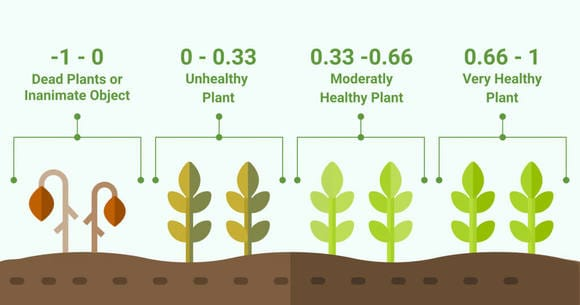

Bonus: Make a timeseries plot from the monthly resampled mean NDVI value within the masked NDVI layer

### Compute statistics

Compute statistics using the `.describe()` method for dataframes

Close the cluster now that we are done with the analysis

In [ ]:
# close the cluster
client.close()